In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

from ElectionForecasting.src.root import ROOT_DIR

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
economic_data_df = pd.read_csv(
    f'{ROOT_DIR}/data/dataland/dataland_economic_data_1984_2023.csv', index_col=0, parse_dates=True
)
economic_data_df['transformed_inflation'] = np.log(np.sqrt(np.abs(economic_data_df['year_on_year_inflation'])))
desc_stats = economic_data_df[['year_on_year_gdp_pct_change', 'unemployment_rate', 'year_on_year_inflation', 'year_on_year_stock_mkt_pct_change', 'transformed_inflation']].describe()
desc_stats


,year_on_year_gdp_pct_change,unemployment_rate,year_on_year_inflation,year_on_year_stock_mkt_pct_change,transformed_inflation
count,173.000000,173.000000,173.000000,173.000000,173.000000
mean,0.026838,0.056191,0.045601,0.093803,-1.797502
std,0.027020,0.018566,0.049399,0.160432,0.521874
min,-0.096000,0.026000,-0.005000,-0.319000,-3.453878
25%,0.017000,0.042000,0.015000,0.011000,-2.099853
50%,0.030000,0.053000,0.026000,0.065000,-1.824829
75%,0.041000,0.064000,0.051000,0.175000,-1.487965
max,0.188000,0.112000,0.189000,0.733000,-0.833004


In [3]:
economic_data_df[economic_data_df.year_on_year_inflation==-.005]

,year_on_year_gdp_pct_change,unemployment_rate,year_on_year_inflation,year_on_year_stock_mkt_pct_change,transformed_inflation
date,,,,,
1999-09-30,0.057,0.064,-0.005,0.083,-2.649159


In [9]:
economic_data_df

,year_on_year_gdp_pct_change,unemployment_rate,year_on_year_inflation,year_on_year_stock_mkt_pct_change,transformed_inflation
date,,,,,
1980-03-31,0.013,0.026,0.184,0.391,-0.846410
1980-06-30,0.021,0.029,0.179,0.442,-0.860185
1980-09-30,0.030,0.033,0.163,0.504,-0.907003
1980-12-31,0.038,0.036,0.161,0.690,-0.913175
1981-03-31,0.047,0.036,0.152,0.733,-0.941937
...,...,...,...,...,...
2022-03-31,0.005,0.034,0.069,-0.031,-1.336824
2022-06-30,0.000,0.034,0.073,-0.136,-1.308648
2022-09-30,0.065,0.036,0.072,-0.157,-1.315545


<Axes: xlabel='date'>

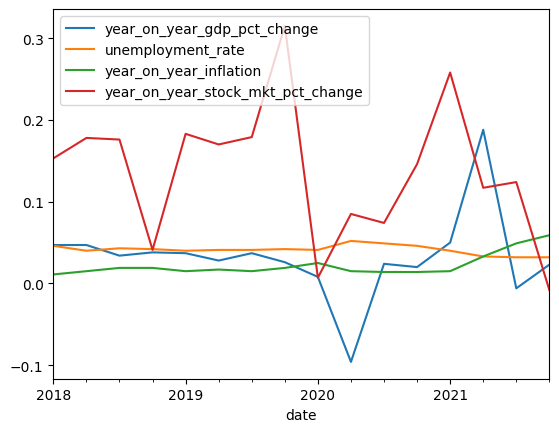

In [8]:
economic_data_df[(economic_data_df.index > '2018') & (economic_data_df.index < '2022')][['year_on_year_gdp_pct_change', 'unemployment_rate',
       'year_on_year_inflation', 'year_on_year_stock_mkt_pct_change']].plot()

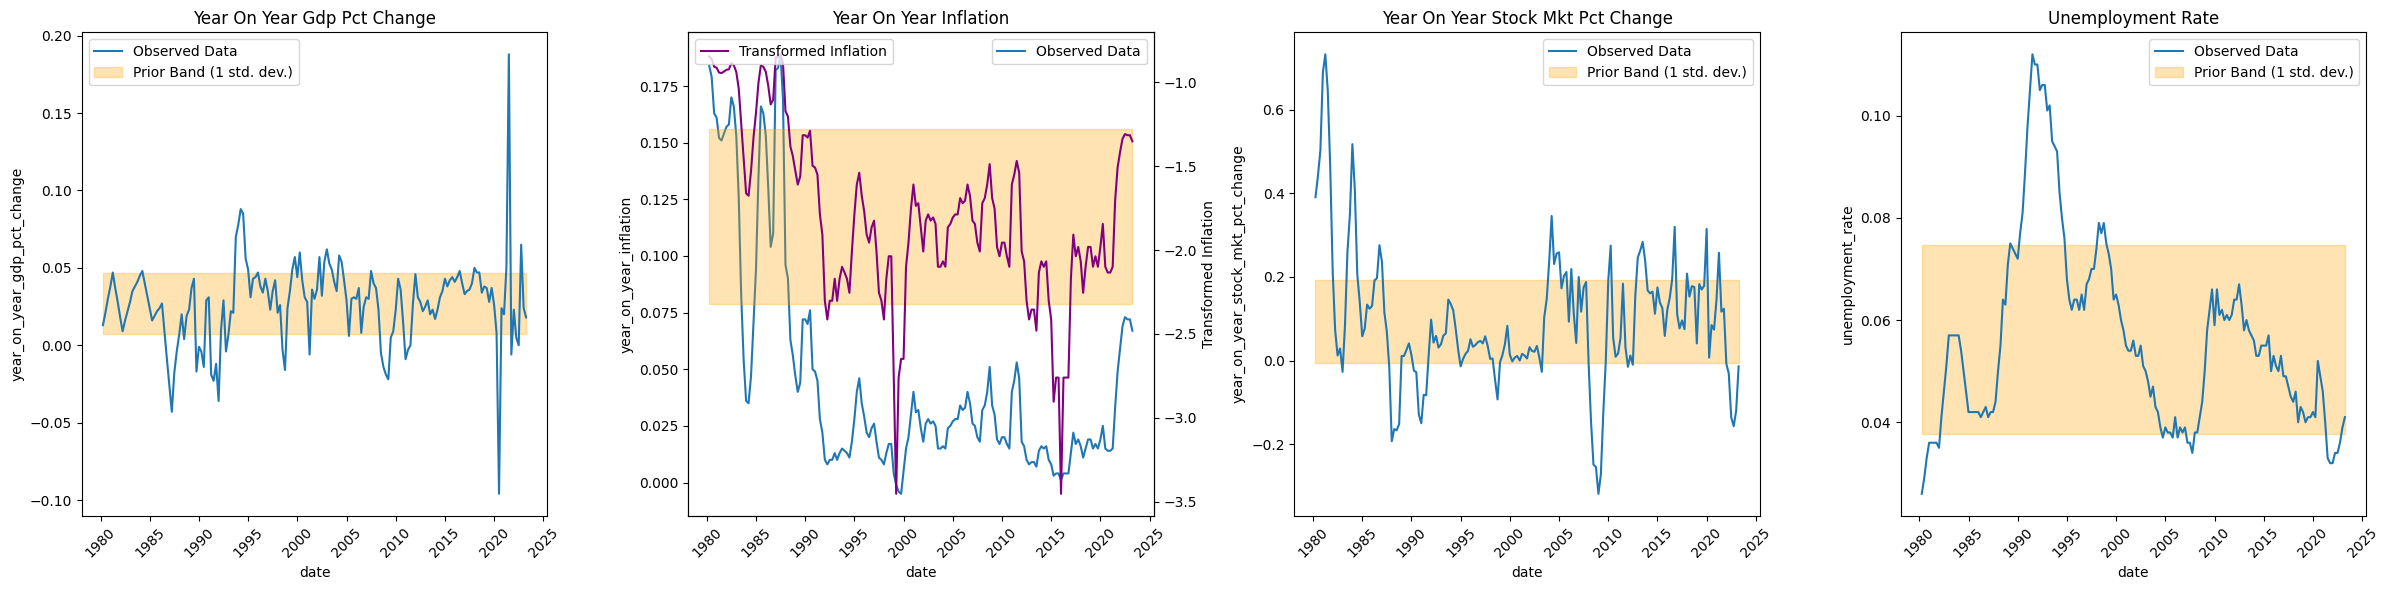

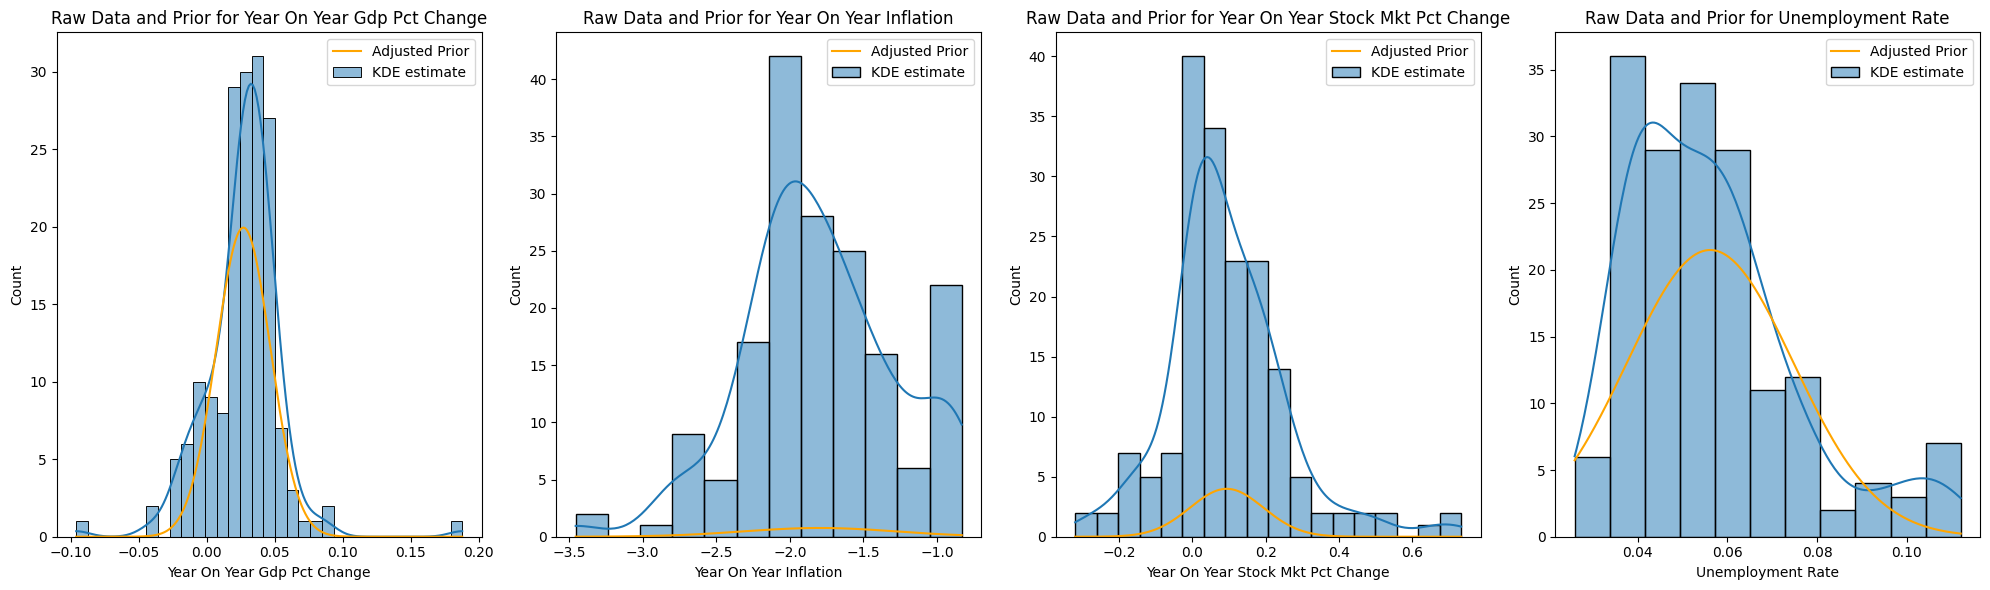

                          mu     sigma
betas_gdp           0.027000  0.020000
mu_hyperparam       0.046000  0.020000
sig_hyperparam      0.049000  0.020000
betas_stk_mkt       0.094000  0.100000
betas_unemployment  0.056191  0.018566
betas_inflation    -1.798000  0.522000


In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, halfnorm

df = economic_data_df.copy()

# Calculate observed statistics for each variable
observed_stats = {
    'betas_gdp': {'mean': df['year_on_year_gdp_pct_change'].mean(), 'std': df['year_on_year_gdp_pct_change'].std()},
    'betas_inflation': {'mean': df['year_on_year_inflation'].mean(), 'std': df['year_on_year_inflation'].std()},
    'betas_stk_mkt': {'mean': df['year_on_year_stock_mkt_pct_change'].mean(), 'std': df['year_on_year_stock_mkt_pct_change'].std()},
    'betas_unemployment': {'mean': df['unemployment_rate'].mean(), 'std': df['unemployment_rate'].std()}
}

adjusted_params = {
    'betas_gdp': {'mu': 0.027, 'sigma': 0.020},
    'mu_hyperparam': {'mu': 0.046, 'sigma': 0.020},
    'sig_hyperparam': {'mu': 0.049, 'sigma': 0.020},
    'betas_stk_mkt': {'mu': 0.094, 'sigma': 0.100},
    'betas_unemployment': {'mu': observed_stats['betas_unemployment']['mean'], 'sigma': observed_stats['betas_unemployment']['std']},
    'betas_inflation': {'mu': -1.798, 'sigma': 0.522}
}

# Create time series plots with prior bands and transformed inflation variable
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True)
variables_to_plot = ['year_on_year_gdp_pct_change', 'year_on_year_inflation', 'year_on_year_stock_mkt_pct_change', 'unemployment_rate']
prior_variables = ['betas_gdp', 'betas_inflation', 'betas_stk_mkt', 'betas_unemployment']

for ax, var, prior_var in zip(axes, variables_to_plot, prior_variables):
    sns.lineplot(x=df.index, y=df[var], ax=ax, label='Observed Data')
    prior_params = adjusted_params[prior_var]
    mu = prior_params.get('mu', 0)
    sigma = prior_params.get('sigma', 0)
    if var == 'year_on_year_inflation':
        ax2 = ax.twinx()
        transformed_inflation = np.log(np.sqrt(np.abs(df[var])))
        sns.lineplot(x=df.index, y=transformed_inflation, ax=ax2, color='purple', label='Transformed Inflation')
        ax2.set_ylabel('Transformed Inflation')
        ax2.legend(loc='upper left')
        ax2.fill_between(df.index, mu - sigma, mu + sigma, color='orange', alpha=0.3, label='Prior Band (1 std. dev.)')
    else:
        ax.fill_between(df.index, mu - sigma, mu + sigma, color='orange', alpha=0.3, label='Prior Band (1 std. dev.)')
    ax.set_title(f'{var.replace("_", " ").title()}')
    ax.set_ylabel(f'{var}')
    ax.legend()

# Rotate x-axis titles for better visibility and adjust layout
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.savefig(f'{ROOT_DIR}/plots/static_plots/priors/time_series.png')
plt.show()

# Create subplots for comparing prior samples to observed data statistics
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
prior_mapping = {
    'year_on_year_gdp_pct_change': 'betas_gdp',
    'year_on_year_inflation': 'betas_inflation',
    'year_on_year_stock_mkt_pct_change': 'betas_stk_mkt',
    'unemployment_rate': 'betas_unemployment'
}

for ax, var in zip(axes, variables_to_plot):
    # Use the transformed data for year-on-year inflation
    if var == 'year_on_year_inflation':
        sns.histplot(transformed_inflation, kde=True, ax=ax, label='KDE estimate')
    else:
        sns.histplot(df[var], kde=True, ax=ax, label='KDE estimate')
        
    prior_var = prior_mapping[var]
    prior_params = adjusted_params[prior_var]
    mu = prior_params.get('mu', 0)
    sigma = prior_params.get('sigma', 0)
    x_values = np.linspace(df[var].min(), df[var].max(), 1000) if var != 'year_on_year_inflation' else np.linspace(transformed_inflation.min(), transformed_inflation.max(), 1000)
    y_values = norm.pdf(x_values, loc=mu, scale=sigma)
    ax.plot(x_values, y_values, color='orange', label='Adjusted Prior')
    ax.set_title(f'Raw Data and Prior for {var.replace("_", " ").title()}')
    ax.set_xlabel(f'{var.replace("_", " ").title()}')
    ax.legend()

plt.tight_layout()
plt.savefig(f'{ROOT_DIR}/plots/static_plots/priors/histograms.png')
plt.show()

# Create a table to define the new adjusted priors
new_adjusted_priors_table = pd.DataFrame.from_dict(adjusted_params, orient='index', columns=['mu', 'sigma'])
print(new_adjusted_priors_table)
